Data PreProcessing

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")

# Data Exploration
print("First 5 rows of the dataset:")
print(df.head())
print(df.gender.unique())
print(df.smoking_history.unique())
print(df.info())

# Encode categorical variables
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['smoking_history'] = label_encoder.fit_transform(df['smoking_history'])

# Save preprocessed data for model building
df.to_csv('preprocessed_diabetes_data.csv', index=False)

print("Data preprocessing completed and saved as 'preprocessed_diabetes_data.csv'")

First 5 rows of the dataset:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
['Female' 'Male' 'Other']
['never' 'No Info' 'current' 'former' 'ever' 'not current']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  -----

Checking Processed Dataset

In [4]:
df = pd.read_csv('preprocessed_diabetes_data.csv')
df.head()

gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32   
3       0  36.0             0              0                1  23.45   
4       1  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

Load and Prepare Data - For 'Diabetes_Prediction'

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('preprocessed_diabetes_data.csv')

Features = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Target = 'diabetes'

# Separate features and target variable
X = data[Features]
y = data[Target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Training set shape: (80000, 8), Test set shape: (20000, 8)


Handle Class Imbalance - Oversampling with SMOTE 

In [6]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set size: {y_train.value_counts()}")
print(f"Resampled training set size: {y_train_resampled.value_counts()}")


Original training set size: diabetes
0    73200
1     6800
Name: count, dtype: int64
Resampled training set size: diabetes
1    73200
0    73200
Name: count, dtype: int64


Model Training and Hyperparameter Tuning

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import time
from sklearn.model_selection import train_test_split

# Subset the data
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train_resampled, y_train_resampled, train_size=0.5, stratify=y_train_resampled, random_state=42
)

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=-1, warm_start=True)

# Refined hyperparameter grid
param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Use fewer splits for StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Start time for Randomized Search
start_time = time.time()

# Randomized Search with Cross-Validation
randomized_search = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=param_dist, 
    n_iter=10,  # Reduced iterations
    cv=kf, 
    random_state=42, 
    n_jobs=-1, 
    verbose=1
)
randomized_search.fit(X_train_subset, y_train_subset)

# End time for Randomized Search
end_time = time.time()
training_time = (end_time - start_time) / 60  # Convert to minutes

# Get the best model from the Randomized Search
best_rf_model = randomized_search.best_estimator_

print("Best Parameters Found: ", randomized_search.best_params_)
print(f"Training Time: {training_time:.2f} minutes")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s


Best Parameters Found:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Training Time: 3.52 minutes


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.2s finished


Model Evaluation

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.3s finished


Test Set Accuracy: 0.9463
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     18300
           1       0.65      0.80      0.72      1700

    accuracy                           0.95     20000
   macro avg       0.82      0.88      0.84     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[17572   728]
 [  346  1354]]


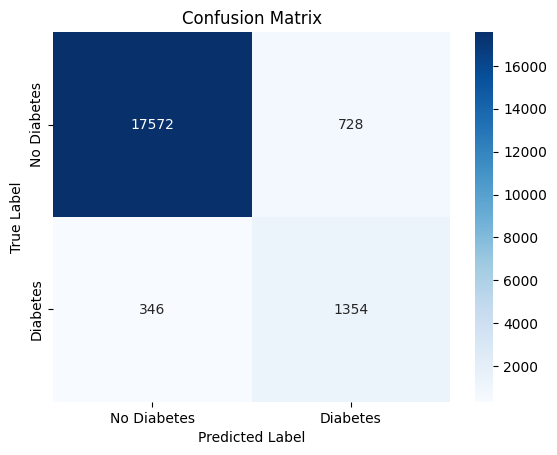

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = best_rf_model.predict(X_test_scaled)

# Print evaluation metrics
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Adjust Decision Threshold

In [9]:
import numpy as np
from sklearn.metrics import roc_curve

# Get probability predictions
y_prob = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)

# Find the optimal threshold (you can adjust this based on your needs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Evaluate performance with the new threshold
print("Optimized Test Set Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("Optimized Classification Report:\n", classification_report(y_test, y_pred_optimal))


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Optimized Test Set Accuracy: 0.8925
Optimized Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     18300
           1       0.44      0.91      0.59      1700

    accuracy                           0.89     20000
   macro avg       0.71      0.90      0.76     20000
weighted avg       0.94      0.89      0.91     20000



[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.2s finished


Trained Machine Learning Model - 'Diabetes Prediction'

In [10]:
import pickle

# Save the best model as a .pkl file
model_path = 'Diabetes_Prediction_Model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

print(f"Best model saved as '{model_path}'")


Best model saved as 'Diabetes_Prediction_Model.pkl'


In [ ]:
input_data = (1,28.0,0,0,4,27.32,5.7,158)
with open('Diabetes_Prediction_Model.pkl','rb') as model_file:
  model=pickle.load(model_file)


# change the input data to a numpy array
input_data_as_numpy_array= np.asarray(input_data)

# reshape the numpy array as we are predicting for only on instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

pred= model.predict(input_data_reshaped)






[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


In [26]:
print(pred)

[1]
